# Unsupervised Machine Learning Analysis
## Goal: Search for Interesting Clusters That Represent Unique Patterns of Electricity Usage

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler


In [3]:
# Import test and train data
test = pd.read_feather('data/test.feather')
train = pd.read_feather('data/train.feather')

In [4]:
# Combine datasets
df_all = pd.concat([train, test], ignore_index=True)


In [5]:
# Convert YEAR_MONTH to extract time features
df_all['month'] = df_all['YEAR_MONTH'].dt.month
df_all['year'] = df_all['YEAR_MONTH'].dt.year
df_all['month_sin'] = np.sin(2 * np.pi * df_all['month'] / 12)
df_all['month_cos'] = np.cos(2 * np.pi * df_all['month'] / 12)

# Create lag and rolling features
df_all['lag_1'] = df_all['TOTALKWH'].shift(1)
df_all['lag_12'] = df_all['TOTALKWH'].shift(12)
df_all['rolling_mean_3'] = df_all['TOTALKWH'].shift(1).rolling(3).mean()
df_all = df_all.dropna()
features = ['tempAvg', 'winddirAvg', 'population', 'zipcode', 'longitude', 'latitude', 'density', 'month_sin', 'month_cos', 'lag_1', 'lag_12', 'rolling_mean_3']

# Scale Feature
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_all[features + ['month_sin', 'month_cos']])

In [37]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Try different cluster numbers
best_k = None
best_score = -1
best_labels = None

for k in [2, 3, 4, 5, 6]:
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f'k={k}, silhouette score={score:.4f}')
    
    if score > best_score:
        best_score = score
        best_k = k
        best_labels = labels

print(f'Best number of clusters: {best_k}')
df_all['cluster'] = best_labels

k=2, silhouette score=0.1558
k=3, silhouette score=0.1371
k=4, silhouette score=0.1453
k=5, silhouette score=0.1494
k=6, silhouette score=0.1460
Best number of clusters: 2


As the best number of clusters is 2 according to this tuning exercise, this indicates that KMeans modeling might not be the best clustering method for this task. The data is mostly unimodal or has only one clear separation (e.g., summer vs. winter). KMeans also can't capture temporal continuity or sequence — it's static, not dynamic. <br>
So in the next section, I will try out the time-series shape-based clustering to group Zip Codes based on their monthly TOTALKWH trends over time, with a focus on only pattern similarity instread of raw feature values. 

## Time-Series Shape-Based Clustering

In [6]:
df_all.head()

,TOTALKWH,tempAvg,winddirAvg,population,density,month,month_sin,month_cos,zipcode,latitude,longitude,YEAR_MONTH,year,lag_1,lag_12,rolling_mean_3
12,-0.148049,-1.036934,-0.315280,-0.257779,0.961817,1,0.5,0.866025,93241.0,35.24922,-118.91224,2020-01-01,2020,-1.332556,-1.273660,-0.854888
13,-0.627049,-0.687342,0.031676,-0.884187,-0.673730,1,0.5,0.866025,93242.0,36.44115,-119.73024,2020-01-01,2020,-0.148049,0.142464,-0.732124
14,0.015912,-1.460614,-0.698592,-0.966886,-1.571777,1,0.5,0.866025,93243.0,34.84057,-118.81769,2020-01-01,2020,-0.627049,-0.015579,-0.702551
15,-1.096602,-1.460614,-0.698592,-0.966886,-1.571777,1,0.5,0.866025,93243.0,34.84057,-118.81769,2020-01-01,2020,0.015912,-0.379155,-0.253062
16,0.648453,-0.931565,0.817021,0.799380,-0.010411,1,0.5,0.866025,93245.0,36.28614,-119.83405,2020-01-01,2020,-1.096602,-1.020352,-0.569246


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import silhouette_score

C:\Users\Lydia\AppData\Local\Temp\ipykernel_27800\2642988853.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_pivoted = df_pivoted.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)


Metric: dtw, Clusters: 2, Silhouette Score: 0.1083
Metric: dtw, Clusters: 3, Silhouette Score: 0.0947
Metric: dtw, Clusters: 4, Silhouette Score: 0.0825
Metric: dtw, Clusters: 5, Silhouette Score: 0.0724
Metric: dtw, Clusters: 6, Silhouette Score: 0.0747

 Best Model → Metric: dtw, Clusters: 2, Silhouette Score: 0.1083


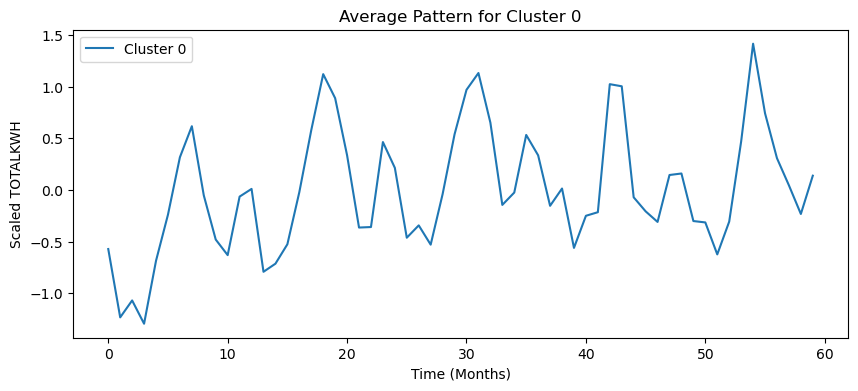

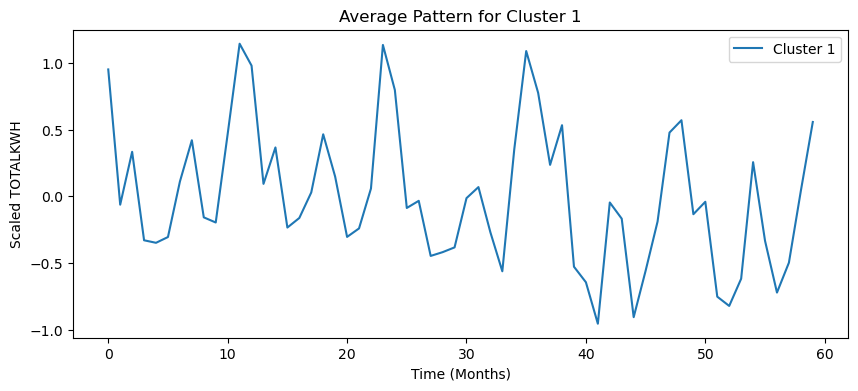

cluster
1    413
0    378
Name: count, dtype: int64


In [ ]:
# Pivot the dataframe: rows → Zip Code, columns → YEAR_MONTH, values → TOTALKWH
df_agg = df_all.groupby(['zipcode', 'YEAR_MONTH'])['TOTALKWH'].mean().reset_index()
df_pivoted = df_agg.pivot(index='zipcode', columns='YEAR_MONTH', values='TOTALKWH')

# Fill missing values (very important!)
df_pivoted = df_pivoted.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)

# Reshape to 3D array [n_samples, n_timestamps, 1]
X_series = df_pivoted.values.reshape((df_pivoted.shape[0], df_pivoted.shape[1], 1))

# Scale each time series to zero mean and unit variance
scaler = TimeSeriesScalerMeanVariance()
X_scaled = scaler.fit_transform(X_series)

# Hyperparameter tuning
best_k = None
best_metric = None
best_score = -1
best_labels = None

for metric in ['dtw', 'softdtw']:
    for k in [2, 3, 4]:
        model = TimeSeriesKMeans(n_clusters=k, metric=metric, random_state=42, verbose=False)
        labels = model.fit_predict(X_scaled)
        
        # Silhouette score measures how well-separated the clusters are
        score = silhouette_score(X_scaled, labels, metric=metric)
        print(f'Metric: {metric}, Clusters: {k}, Silhouette Score: {score:.4f}')
        
        if score > best_score:
            best_score = score
            best_k = k
            best_metric = metric
            best_labels = labels
            best_model = model

print(f'\n Best Model → Metric: {best_metric}, Clusters: {best_k}, Silhouette Score: {best_score:.4f}')
df_pivoted['cluster'] = best_labels

# Plot average series per cluster
for cluster in range(best_k):
    plt.figure(figsize=(10, 4))
    cluster_series = X_scaled[best_labels == cluster].squeeze()
    avg_series = np.mean(cluster_series, axis=0)
    plt.plot(avg_series, label=f'Cluster {cluster}')
    plt.title(f'Average Pattern for Cluster {cluster}')
    plt.xlabel('Time (Months)')
    plt.ylabel('Scaled TOTALKWH')
    plt.legend()
    plt.show()

# Check cluster assignments
print(df_pivoted['cluster'].value_counts())